In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.decomposition import NMF, TruncatedSVD

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [71]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]


def sites_to_sparse_tfidf(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
    test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

    y = train_data[target_col]

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
    train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                                  for i in range(train_test_df_sites.shape[0])]

    tfidf = TfidfVectorizer(max_df=0.9).fit(train_test_df_sites_array) #TfidfVectorizer()
    X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
             train_duplicates_mask, test_duplicates_mask]


def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix


def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

def site_times_to_sparse(sitetimes, col_num=0, vocabulary={}):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                if len(vocabulary):
                    col.append(vocabulary[int(site)])
                else:
                    col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse



def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse, \
                                  train_duplicates_mask, test_duplicates_mask, \
                                  train_site_times_sparse = None, test_site_times_sparse = None, \
                                train_sites_sequence=None, test_sites_sequence=None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, \
                                 train_site_times_sparse, train_sites_sequence], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, \
                                test_site_times_sparse, test_sites_sequence], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
        
    #X_train_sparse = hstack([X_train_sparse, train_duplicates_mask], dtype=float).tocsr()
    #X_test_sparse = hstack([X_test_sparse, test_duplicates_mask], dtype=float).tocsr() 
    return [X_train_sparse, X_test_sparse]


def sparse_matrix_to_vw(X_sparse, sites_columns_num, vocabulary, y=None, weights=None, \
                        mark_duplicates=False, csoaa=False, predictions={}):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    sequence = {}
    
    #X_sparse = X_sparse_full[:,:-1]
    
    add_features = True

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if add_features:
                if c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                    prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                    #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                    day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                    #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                    start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                    #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                    daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                    #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                    session_timespan[r] = " |jsession_timespan time:{}".format(int(X_sparse[r,c]))
                    #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                    unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                    #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                    site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                    #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                    top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                    bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                    fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                    youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                    continue
                elif c >= X_sparse.shape[1] - 10:
                    if r not in sequence:
                        sequence[r] = " |ksequence " + \
              ' '.join(filter(lambda a: a != "0", X_sparse[r,-10:].todense().astype(int).astype(str).tolist()[0]))
                    continue
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                else:
                    if y is not None:
                        y_label = str(y[r])
                        if csoaa:
                            alllabels = []
                            if r in predictions:
                                #alllabels = [str(lbl) + ":2" for lbl in range(1,551)]
                                for lbl in sorted(predictions[r]):
                                    if lbl == y[r]:
                                        alllabels.append(str(y[r]) + ":0")
                                    else:
                                        alllabels.append(str(lbl) + ":1")
                                    
                            else:
                                alllabels = [str(lbl) + ":1" for lbl in range(1,551)]
                                alllabels[y[r]-1] = str(y[r]) + ":0"                           
                            y_label = ' '.join([str(pus) for pus in alllabels])
                        if mark_duplicates and int(X_sparse_full[r, -1]): # duplicate row indicator
                            sessions[r] = y_label + ' 0.3' + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        else:
                            if weights is not None:
                                sessions[r] = y_label + ' ' + str(weights[y[r]-1]) + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c]) #' ' + str(weights[y[r]-1]) +
                            else:
                                sessions[r] = y_label + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                    else:
                        if csoaa:
                            if r in predictions:
                                y_label = ' '.join([str(pus) for pus in sorted(predictions[r])])
                            else:
                                y_label = ' '.join([str(pus) for pus in range(1,551)])
                        else:
                            y_label = ""
                        sessions[r] = y_label + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
            elif c > X_sparse.shape[1] - sites_columns_num and c < X_sparse.shape[1] - 10:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes, "sequence": sequence}



def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()
    
    
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [69]:
def calc_predictions(train_data, test_data, site_dic, user_dic, min_users, max_users, permutations=False):
    train_row_users = {}
    test_row_users = {}
    
    sites_cols = ['site' + str(c) for c in range(1,10+1)]
    
    # Add predictions from the dataframe (based on uniquely visited site)
    for r, v in train_data[["prediction"]].iterrows():
        if int(v) != 0:
            train_row_users[r] = {int(v): 1}  
    
    for r, v in test_data[["prediction"]].iterrows():
        if int(v) != 0:
            test_row_users[r] = {int(v): 1}
    
    # Add predictions if a website in session was visited by less than num_users_for_prediction
    for r, row in train_data[sites_cols+["target"]].iterrows():
        if r in train_row_users:
            continue
        session_predictions = {}
        for site in row:
            predictions = set([])
            if site in site_dic and site in user_dic[int(row["target"])] \
                          and len(site_dic[site]) in range(min_users, max_users):
                predictions = set(site_dic[site])
            if len(predictions):
                for puser in predictions:
                    if puser in session_predictions:
                        session_predictions[puser] +=1
                    else:
                        session_predictions[puser] = 1
                #session_predictions |= predictions
        if len(session_predictions):
            train_row_users[r] = session_predictions
    
    
    for r, row in test_data[sites_cols].iterrows():
        if r in test_row_users:
            continue
        session_predictions = {}
        for site in row:
            predictions = set([])
            if site in site_dic and len(site_dic[site]) in range(min_users, max_users):
                predictions = set(site_dic[site])
            if len(predictions):
                for puser in predictions:
                    if puser in session_predictions:
                        session_predictions[puser] +=1
                    else:
                        session_predictions[puser] = 1
                #session_predictions |= predictions
        if len(session_predictions):
            test_row_users[r] = session_predictions
    
    
    
    #Identify sessions with identical sites sequence
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)

    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    
    train_user_dup_rows_dict = {}
    train_dup_row_users_dict = {}

    #test_dup_rows_dict = {} 

    
    
    for r, row in train_data.ix[train_index_dup][sites_cols+["target"]].iterrows():
        if row["target"] in train_user_dup_rows_dict:
            if tuple(row[sites_cols]) in train_user_dup_rows_dict[row["target"]]:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] += 1
            else:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] = 1 
        else:
            train_user_dup_rows_dict[row["target"]] = {tuple(row[sites_cols]): 1}

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            train_dup_row_users_dict[tuple(row[sites_cols])].add(row["target"])
        else:
            train_dup_row_users_dict[tuple(row[sites_cols])] = set([row["target"]])
    
    # Make predictions based on duplicate sessions
    for r, row in train_data.ix[train_index_dup][sites_cols].iterrows():        
        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            if r in train_row_users:
                pass #don't overwright predictions from the dataframe
                #train_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
            else:
                train_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]
    
    for r, row in test_data.ix[test_index_dup][sites_cols].iterrows():  
        #if tuple(row[sites_cols]) in test_dup_rows_dict:
            #test_dup_rows_dict[tuple(row[sites_cols])] += 1
        #else:
            #test_dup_rows_dict[tuple(row[sites_cols])] = 1

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            if r in test_row_users:
                pass #don't overwright predictions from the dataframe
                #test_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
            else:
                test_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]
    
    if not permutations:
        return train_row_users, test_row_users
    
    
    # Find users who visited 2, 3, 4 websites
    site_pairs = {}
    for r, row in train_data[sites_cols+["target"]].iterrows():
        unique_sites = Counter(row).keys()
        if 0 in unique_sites:
            del unique_sites[unique_sites.index(0)]
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if tuple(subset) in site_pairs:
                    #site_pairs[tuple(subset)].add(row["target"])
                #else:
                    #site_pairs[tuple(subset)] = set([row["target"]])
    
    # Add predictions to train data based on 2 visited websites
    for r, row in train_data[sites_cols+["target"]].iterrows():
        if r in train_row_users:
            continue
        unique_sites = Counter(row).keys()
        if 0 in unique_sites:
            del unique_sites[unique_sites.index(0)]
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if tuple(subset) in site_pairs:
                    if r in train_row_users:
                        train_row_users[r] |= site_pairs[subset]
                    else:
                        train_row_users[r] = set(site_pairs[subset])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if tuple(subset) in site_pairs:
                    if r in test_row_users:
                        train_row_users[r] |= site_pairs[subset]
                    else:
                        train_row_users[r] = set(site_pairs[subset])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if tuple(subset) in site_pairs:
                    #if r in test_row_users:
                        #train_row_users[r].add(site_pairs[subset])
                    #else:
                        #train_row_users[r] = set(site_pairs[subset])
    
    # Add predictions to test data based on 2 visited websites
    for r, row in test_data[sites_cols].iterrows():
        if r in test_row_users:
            continue
        unique_sites = Counter(row).keys()
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if subset in site_pairs:
                    if r in test_row_users:
                        test_row_users[r] |= site_pairs[subset]
                    else:
                        test_row_users[r] = set(site_pairs[subset])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if subset in site_pairs:
                    if r in test_row_users:
                        test_row_users[r] |= site_pairs[subset]
                    else:
                        test_row_users[r] = set(site_pairs[subset])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if subset in site_pairs:
                    #if r in test_row_users:
                        #test_row_users[r].add(site_pairs[subset])
                    #else:
                        #test_row_users[r] = set(site_pairs[subset])
        
    
    
    return train_row_users, test_row_users

In [5]:
def create_user_site_dic(train_data, site_freq_pkl):
    user_dic = {}
    site_dic = {}

    pkl_file = open(site_freq_pkl, 'rb')
    site_freq = pickle.load(pkl_file)
    top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]

    for i, v in train_data.iterrows():
        if v.target not in user_dic:
            user_dic[v.target] = {}
        for site in ['site' + str(i) for i in range(1,11)]:
            if v[site] != 0 and v[site] not in top_sites:
                if v[site] in user_dic[v.target]:
                    user_dic[v.target][v[site]] +=1
                else:
                    user_dic[v.target][v[site]] = 1

            if v[site] in site_dic:
                site_dic[v[site]].add(v.target)
            else:
                site_dic[v[site]] = set([v.target])
    
    return user_dic, site_dic

In [6]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [7]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LinearSVC())]
        )

# Let's Start

In [36]:
train_data = pd.read_csv('kaggle_data/full_train_w8.csv')

test_data = pd.read_csv('kaggle_data/full_test.csv')
len(train_data), len(test_data)

(109308, 41177)

In [83]:
M_transformed

NameError: name 'M_transformed' is not defined

In [82]:
train_data[train_data.target == 1307]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,bot30_portion,prediction,target
62823,16,347,347,6,0,0,0,0,0,0,...,347,9,3,0,0.000000,0.0,0.000000,0.000000,0,1307
62824,1917,1917,1917,0,0,0,0,0,0,0,...,1917,10,2,0,0.000000,0.0,0.000000,0.000000,0,1307
62825,22,22,69,22,87,260,260,22,22,106,...,260,10,2,0,0.000000,0.0,0.010399,0.000000,0,1307
62826,106,4175,106,106,4175,106,67,65,4184,85,...,106,10,2,0,0.000000,0.0,0.826087,0.173913,0,1307
62827,67,85,11,4184,38,3740,55,67,82,4189,...,11,10,2,0,0.333333,0.0,1.000000,0.000000,0,1307
62828,82,38,4184,4189,3740,55,38,4189,11,85,...,82,10,2,0,0.000000,0.0,1.000000,0.000000,0,1307
62829,4189,11,4184,78,4184,4184,82,67,7,67,...,82,10,2,0,0.014286,0.0,0.557143,0.428571,0,1307
62830,7,67,1930,151,3471,67,646,115,3519,38,...,67,10,2,0,0.000000,0.0,0.962264,0.037736,0,1307
62831,646,3740,38,11,3740,7,4197,88,82,4189,...,646,10,2,0,0.000000,0.0,0.250000,0.000000,0,1307
62832,3740,4189,4184,4184,7,7,3471,106,106,4175,...,3471,10,2,0,0.006734,0.0,0.043771,0.090909,0,1307


In [81]:
train_data[train_data.target == 2179]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,bot30_portion,prediction,target
26721,16,347,347,347,347,6,0,0,0,0,...,347,9,3,0,0.000000,0.0,0.000000,0.000000,0,2179
26722,1917,1917,0,0,0,0,0,0,0,0,...,1917,10,2,0,0.000000,0.0,0.000000,0.000000,0,2179
26723,22,22,90,22,22,87,412,260,22,4175,...,260,10,2,0,0.000000,0.0,0.008681,0.000000,0,2179
26724,22,22,4175,106,4175,106,106,106,4175,106,...,4175,10,2,0,0.000000,0.0,0.583333,0.416667,0,2179
26725,4175,106,4184,65,4184,38,11,4184,3740,55,...,106,10,2,0,0.071429,0.0,0.928571,0.071429,0,2179
26726,4189,38,3740,55,82,4184,10708,4184,82,4189,...,55,10,2,0,0.000000,0.0,0.500000,0.500000,2179,2179
26727,4189,38,4197,82,3740,38,4189,11,85,10708,...,3740,10,2,0,0.500000,0.0,0.000000,0.000000,2179,2179
26728,4189,4184,67,10708,4184,4184,67,7,67,151,...,4184,10,2,0,0.000000,0.0,0.014286,0.985714,2179,2179
26729,67,11,151,1930,151,115,3471,115,3519,4197,...,3471,10,2,0,0.000000,0.0,0.006536,0.000000,0,2179
26730,115,4197,3740,38,11,38,7,82,4189,11,...,4197,10,2,0,0.000000,0.0,0.250000,0.750000,0,2179


In [8]:
y_train_pred = pd.DataFrame(index=train_data.index)
y_train_pred["user"]= train_data["prediction"]
y_test_pred = pd.DataFrame(index=test_data.index)
y_test_pred["user"]= test_data["prediction"]

In [9]:
#user_dic, site_dic = create_user_site_dic(train_data, "kaggle_data/site_freq.pkl")

In [951]:
# Removing first predictions
first_predictions_train = train_data[train_data.prediction > 0].index
first_predictions_test = test_data[test_data.prediction > 0].index

train_data.drop(first_predictions_train, inplace=True)
test_data.drop(first_predictions_test, inplace=True)
len(train_data), len(test_data)

(86687, 33261)

In [10]:
# Removing duplicated sessions
train_index_dup = train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)].index
test_index_dup = test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)].index
print len(train_index_dup), len(test_index_dup)

train_data.drop(train_index_dup, inplace=True)
test_data.drop(test_index_dup, inplace=True)
len(train_data), len(test_data)

5953 4229


(103355, 36948)

In [952]:
#Removing 0 iteration
train_data.drop(iter0_train_index, inplace=True)
test_data.drop(iter0_test_index, inplace=True)
len(train_data), len(test_data)

(23363, 10201)

In [953]:
#Removing 1 iteration
train_data.drop(iter1_train_index, inplace=True)
test_data.drop(iter1_test_index, inplace=True)
len(train_data), len(test_data)

(5953, 4133)

In [695]:
#Removing 2 iteration
train_data.drop(iter2_train_index, inplace=True)
test_data.drop(iter2_test_index, inplace=True)
len(train_data), len(test_data)

(23363, 10201)

In [696]:
#Removing 3 iteration
train_data.drop(iter3_train_index, inplace=True)
test_data.drop(iter3_test_index, inplace=True)
len(train_data), len(test_data)

(5953, 4133)

In [914]:
# Sessions with websites that were visited by less than 3 users
train_predictions, test_predictions = calc_predictions(train_data, test_data, \
                                                       site_dic, user_dic, 100, 2000)
less_3_train_index = [k for k, v in sorted(train_predictions.items())]
less_3_test_index = [k for k, v in sorted(test_predictions.items())]

train_data = pd.DataFrame(train_data.ix[less_3_train_index])
test_data = pd.DataFrame(test_data.ix[less_3_test_index])
len(train_data), len(test_data)

(17410, 6068)

In [983]:
#iter0_train_index = train_data.index
#iter0_test_index = test_data.index
iter1_train_index = train_data.index
iter1_test_index = test_data.index
#iter2_train_index = train_data.index
#iter2_test_index = test_data.index
#iter3_train_index = train_data.index
#iter3_test_index = test_data.index

In [275]:
%%time
#train_predictions, test_predictions = calc_predictions(train_data, test_data, \
                                                       #site_dic, user_dic, 3)

CPU times: user 16.5 s, sys: 128 ms, total: 16.6 s
Wall time: 16.4 s


In [201]:
# Not needed for CSOAA
#for k, v in [[k, v] for k, v in test_predictions.items() if len(v) < 2]:
    #test_data.set_value(k, -1, v[0], takeable=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff86e18a350>]], dtype=object)

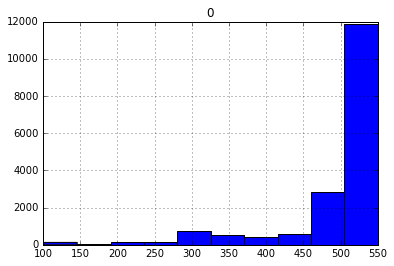

In [916]:
pd.DataFrame([len(v) for k, v in train_predictions.items()]).hist()

In [204]:
np.max([len(v) for k, v in train_predictions.items()])

92

In [199]:
len([[k, v] for k, v in train_predictions.items() if len(v) < 2])

22621

In [37]:
train_site_sequence = csr_matrix(train_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)
test_site_sequence = csr_matrix(test_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)

In [38]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 44 s, sys: 244 ms, total: 44.3 s
Wall time: 43.9 s


In [72]:
train_test_df = pd.concat([train_data, test_data])
train_index_full = list(train_data.index)
session_length = 10
train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for \
                                c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
test_index_full = list(test_data.index)
test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for \
                                c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]].index)
train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

y = train_data["target"]

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                              for i in range(train_test_df_sites.shape[0])]

tfidf = TfidfVectorizer(analyzer=str.split, \
                        max_df=0.9, ngram_range=(1,3)).fit(train_test_df_sites_array) 
X_train_test_sparse = tfidf.transform(train_test_df_sites_array)
inv_vocabulary = {v: int(re.search("s_(\d+)$", k).group(1)) for k, v in tfidf.vocabulary_.iteritems()}
vocabulary = {int(re.search("s_(\d+)$", k).group(1)): v for k, v in tfidf.vocabulary_.iteritems()}
sites_columns_num = X_train_test_sparse.shape[1]
#X_train_test_sparse = NMF(n_components=10000).fit_transform(X_train_test_sparse)


# Convert site times to sparse format
#site_times_sparse = site_times_to_sparse(site_times, sites_columns_num+1, vocabulary)
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]


X_train_sparse_sites = X_train_test_sparse[:len(train_data)]
X_test_sparse_sites = X_train_test_sparse[len(train_data):]

class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

#y_weights = [round(np.max(Counter(y_for_vw).values())/float(v), 3) for k, v in sorted(Counter(y_for_vw).items())]
y_weights = [(np.sum(Counter(y_for_vw).values()) - v + min((Counter(y_for_vw).values())))/ \
             float(np.sum(Counter(y_for_vw).values())) for k, v in sorted(Counter(y_for_vw).items())]

print max(y_for_vw)


550


In [22]:
[[v, round(np.max(Counter(y_for_vw).values())/float(v), 3)] for k, v in sorted(Counter(y_for_vw).items(), key = lambda t: t[1])]

[[16, 238.0],
 [16, 238.0],
 [21, 181.333],
 [22, 173.091],
 [24, 158.667],
 [25, 152.32],
 [26, 146.462],
 [28, 136.0],
 [28, 136.0],
 [29, 131.31],
 [29, 131.31],
 [29, 131.31],
 [30, 126.933],
 [30, 126.933],
 [30, 126.933],
 [30, 126.933],
 [31, 122.839],
 [31, 122.839],
 [31, 122.839],
 [31, 122.839],
 [31, 122.839],
 [32, 119.0],
 [32, 119.0],
 [32, 119.0],
 [32, 119.0],
 [33, 115.394],
 [33, 115.394],
 [33, 115.394],
 [33, 115.394],
 [34, 112.0],
 [34, 112.0],
 [34, 112.0],
 [34, 112.0],
 [35, 108.8],
 [35, 108.8],
 [36, 105.778],
 [36, 105.778],
 [36, 105.778],
 [36, 105.778],
 [36, 105.778],
 [36, 105.778],
 [36, 105.778],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [37, 102.919],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [38, 100.211],
 [39, 97.641],
 [39, 97.641],
 [39, 97.641],
 [39, 97.641],
 [39, 97.641],
 [40, 95.2],


In [291]:
class_encoder.transform(np.array(["473"])) +1

ValueError: y contains new labels: ['473']

In [80]:
class_encoder.inverse_transform(55-1)

'1307'

In [163]:
for r, users in test_predictions.items():
    list_users = list(users)
    newc = class_encoder.transform(np.array(list_users).astype('str')) + 1
    test_predictions[r] = newc
    
for r, users in train_predictions.items():
    list_users = list(users)
    newc = class_encoder.transform(np.array(list_users).astype('str')) + 1
    train_predictions[r] = newc

In [73]:
%%time
#X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
                                          #train_duplicates_mask, test_duplicates_mask = \
    #sites_to_sparse_tfidf(train_data, test_data, "target", 10, label_encoder=LabelEncoder())

mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

#X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             #X_test_sparse, test_features, \
                                                              #train_duplicates_mask, test_duplicates_mask,
                                                              #train_site_times_sparse, test_site_times_sparse, \
                                                             #train_site_sequence, test_site_sequence)
print X_train_sparse_sites.shape
print train_features.shape
print train_site_times_sparse.shape
print train_site_sequence.shape

X_train_sparse = hstack([X_train_sparse_sites, train_features, \
                                 train_site_times_sparse, train_site_sequence], dtype=float).tocsr()
X_test_sparse = hstack([X_test_sparse_sites, test_features, \
                                test_site_times_sparse, test_site_sequence], dtype=float).tocsr()      
print X_train_sparse.shape


X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

#y_train_weights = [np.max(Counter(y_train).values()) - v for k, v in sorted(Counter(y_train).items())]

y_train_weights = [(np.sum(Counter(y_train).values()) - v + min((Counter(y_train).values())))/ \
             float(np.sum(Counter(y_train).values())) for k, v in sorted(Counter(y_train).items())]

(109308, 24052)
(109308, 20)
(109308, 24052)
(109308, 10)
(109308, 48134)
CPU times: user 39.1 s, sys: 248 ms, total: 39.4 s
Wall time: 39 s


In [74]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, inv_vocabulary, y_train, weights=y_weights)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, inv_vocabulary, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, inv_vocabulary, y_for_vw, weights=y_weights,\
                               mark_duplicates=False, csoaa=False)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, inv_vocabulary, \
                              mark_duplicates=False, csoaa=False)

CPU times: user 6min 20s, sys: 276 ms, total: 6min 21s
Wall time: 6min 20s


In [29]:
for k in test_vw.keys():
    print k, len(test_vw[k])

youtube_portion 2455
site_longest_time 36948
top30_portion 28711
sequence 36948
sitetimes 36786
unique_site 36948
start_hour 36948
prediction 7818
session_timespan 36614
day_of_week 36948
bot30_portion 16317
fb_portion 6479
sites 36948
daytime 36948


In [30]:
for k in train_vw.keys():
    print k, len(train_vw[k])

youtube_portion 5959
site_longest_time 103355
top30_portion 73672
sequence 103355
sitetimes 102701
unique_site 103355
start_hour 103355
prediction 22621
session_timespan 102554
day_of_week 103355
bot30_portion 41612
fb_portion 14222
sites 103355
daytime 103355


In [43]:
train_vw["sites"]

{0: '315 0.997978190068 |site 16:0.0766939293081 17:0.0905662359097 3537:0.431422850444 37:0.0899193213943 47:0.0882728807182 53:0.0911246592183 5759:0.132000123008',
 1: '315 0.997978190068 |site 17:0.0982508129688 3537:0.117007307866 37:0.0975490075286 47:0.287288597341 53:0.296569856076 56:0.103334418219',
 2: '315 0.997978190068 |site 17:0.139981668502 22:0.470959751645 53:0.140844782948 6:0.110842205474 90:0.13737159143',
 3: '315 0.997978190068 |site 14326:0.576580983575 14334:0.15336053616 22:0.132654235663 87:0.137404244602',
 4: '315 0.997978190068 |site 14326:0.484512418208 14334:0.515487581792',
 5: '315 0.997978190068 |site 1027:0.120727387885 16:0.162804629417 17:0.0961262684541 347:0.115529292419 47:0.187384239698 53:0.096718974426 540:0.11960926027 56:0.101099947431',
 6: '315 0.997978190068 |site 22:0.0626392776744 347:0.268513044494 662:0.278855596764 680:0.0978310607201 690:0.182535636479 90:0.109625383869',
 7: '315 0.997978190068 |site 38:0.0590956847024 662:0.31250

In [850]:
max(y_for_vw)

550

# Handler and Folder

In [75]:
folder = 'kaggle_data/'
handler = '_idf_w8'

keys = ['day_of_week', 'daytime', 'start_hour', 'youtube_portion', 'fb_portion', 'sitetimes', 'sequence']

vw_to_file(train_part_vw["sites"], folder+'train_part'+handler+'.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
vw_to_file(valid_vw["sites"], folder+'valid'+handler+'.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], folder+'train'+handler+'.vw.temp', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], folder+'test'+handler+'.vw', features={x:test_vw[x] for x in keys}, quiet=False)

Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'daytime', 'day_of_week']


In [33]:
!cat {folder}'train'{handler}.vw.temp | shuf > {folder}'train'{handler}.vw

In [180]:
#!cat {folder}train{handler}.vw | grep -Po "((?<= )\d+(?=:0 )|^\d+(?=:0))" > {folder}y_train.csv

In [76]:
f = open(folder+'train_part'+handler+'.vw')
train_part_file = f.readlines()
f.close()

f = open(folder+'train'+handler+'.vw')
train_file = f.readlines()
f.close()

f = open(folder+'valid'+handler+'.vw')
valid_file = f.readlines()
f.close()

f = open(folder+'test'+handler+'.vw')
test_file = f.readlines()
f.close()

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

%%time
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, decay_learning_rate=0.8097261737051064, random_seed=7, \
           initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='logistic', l1=1.2144958188964683e-11, cubic="sbc", sort_features=True, q="sd", noconstant=True)

c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3)
print c_scores, np.mean(c_scores)

In [85]:
%%time
# L1 regularization
!vw --oaa=550 -d kaggle_data/train_part{handler}.vw \
-f kaggle_data/features{handler}.model -b 26 -c \
--passes=100 --decay_learning_rate 0.7 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz 10627 --batch_sz_no_doubling --ignore "i"

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
ignoring namespaces beginning with: i 
using l1 regularization = 1e-11
final_regressor = kaggle_data/features_idf_w8.model
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.7
using cache_file = kaggle_data/train_part_idf_w8.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      457        1       17
1.000000 1.000000            2            2.0      158      457       16
1.000000 1.000000            4            4.0      336       53       16
1.000000 1.000000            8            8.0      379      128       10
1.000000 1.000000           16           16.0       69      128       13
1.000000 1.000000           32           32.0      234

In [78]:
%%time
# L2 Regularization after L1
!vw --oaa=550 -d kaggle_data/train_part{handler}.vw --passes=20 \
-f kaggle_data/initial_model{handler}.vw -b 26 -c -k \
--cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20853 --batch_sz_no_doubling --loss_function='logistic'

creating quadratic features for pairs: bs 
creating cubic features for triples: sbc 
ignoring namespaces beginning with: i 
final_regressor = kaggle_data/initial_model_idf_w10.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train_part_idf_w10.vw.cache
Reading datafile = kaggle_data/train_part_idf_w10.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      457        1       17
1.000000 1.000000            2            2.0      158      457       16
1.000000 1.000000            4            4.0      336       53       16
1.000000 1.000000            8            8.0      379      457       10
1.000000 1.000000           16           16.0       69      128       13
1.000000 1.000000           32           32.0      234      369       16
0.984375 0.96

In [ ]:
--ignore "d" --ignore "b" --ignore "i" --ignore "f" --ignore "c" --ignore "j"

In [171]:
!vw --oaa 550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model --passes 20 --random_seed 7 -c -k --learning_rate=0.45 \
--decay_learning_rate 0.9 --bit_precision 28 --keep "s"

using namespaces beginning with: s 
final_regressor = kaggle_data/initial_model_idf_w8.model
Num weight bits = 28
learning rate = 0.45
initial_t = 0
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_part_idf_w8.vw.cache
Reading datafile = kaggle_data/train_part_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      473        1        6
1.000000 1.000000            2            2.0      422      473        7
1.000000 1.000000            4            4.0      391      473        3
1.000000 1.000000            8            8.0      149      214        3
1.000000 1.000000           17           16.3      233      150       10
1.000000 1.000000           35           32.9      269      473        7
1.000000 1.000000           71           66.8      317      214        6
0.962687 0.925595        

In [103]:
!cat {folder}train{handler}.vw | wc -l

109308


In [ ]:
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l1 1e-11 --l2 1e-11 \
-q "sc" --cubic="sbc" --stage_poly --batch_sz {len(train_data)/6} --batch_sz_no_doubling \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "q" \
--holdout_period 5

- a: prediction
- b: day_of_week 
- c: hour_start
- d: time_of_day
- e:
- f: features
- g: 
- h: site_longest_time
- i: sitetimes
- j: session_timespan
- k: sequence
- s: sites

In [77]:
%%time
!vw --oaa=550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model -b 28 -c -k \
--passes=30 --decay_learning_rate 0.9 --initial_t 0.002337045080352835 \
-l 0.8416950450219994 \
--power_t 0.5 --loss_function='squared' --l1 1e-11 --l2 1e-11 \
-q "sd" -q "sb" --cubic="sbc"  \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a"

creating quadratic features for pairs: sd sb 
creating cubic features for triples: sbc 
using namespaces beginning with: s b c d a 
using l1 regularization = 1e-11
using l2 regularization = 1e-11
final_regressor = kaggle_data/initial_model_idf_w8.model
Num weight bits = 28
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_part_idf_w8.vw.cache
Reading datafile = kaggle_data/train_part_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            2            2.0      368      297       24
1.000000 1.000000            5            5.0      237      208       36
1.000000 1.000000           11           11.0      149      208       28
1.000000 1.000000           23           22.9      260      350       40
0.978643 0.958136           47           46.8      426       64       3

average loss = 0.418117 h

In [1043]:
%%time
!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv

creating quadratic features for pairs: sd sb 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_valid_pred_idf_w8.csv
Num weight bits = 28
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0      214      214       39
0.000000 0.000000            2            2.0      150      150       34
0.250000 0.500000            4            4.0      426      426       46
0.375000 0.500000            8            8.0       50      417       29
0.625000 0.875000           16           16.0      274      249       22
0.593750 0.562500           32           32.0      271      420       51
0.515625 0.437500           64           64.0      189      189       38
0.500000 0.484375          128          128.

In [966]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred.as_matrix()-1)

In [967]:
vw_subm

array([['75'],
       ['1962'],
       ['3342'],
       ..., 
       ['3370'],
       ['958'],
       ['2903']], dtype=object)

In [968]:
y_test_pred = pd.concat([y_test_pred, pd.DataFrame(vw_subm, index=test_data.index, columns=["dup"])], axis=1).fillna(0)

In [969]:
test_data.index

Int64Index([    0,     3,     8,    11,    14,    21,    29,    35,    39,
               47,
            ...
            41099, 41105, 41108, 41120, 41123, 41143, 41154, 41155, 41159,
            41164],
           dtype='int64', length=4133)

In [970]:
y_test_pred

,user,1,2,dup
0,0,0,0,75
1,783,0,0,0
2,0,0,1645,0
3,0,0,0,1962
4,631,0,0,0
5,0,1647,0,0
6,0,1056,0,0
7,0,400,0,0
8,0,0,0,3342
9,0,1505,0,0


In [976]:
my_results = y_test_pred.astype(int).max(axis=1)

In [977]:
my_results = np.transpose([np.array(my_results.tolist())])

In [979]:
write_to_submission_file(my_results,
                         folder+'myresults_submission'+handler+'.csv')

In [189]:
write_to_submission_file(vw_subm,
                         folder+'novw_submission'+handler+'.csv')

In [192]:
!gsutil ls gs://smartandnimble/identifyme/novw_submission{handler}.csv

gs://smartandnimble/identifyme/novw_submission_idf_w8_csoaa.csv


In [191]:
!gsutil cp {folder}novw_submission{handler}.csv gs://smartandnimble/identifyme

Copying file://vw/novw_submission_idf_w8_csoaa.csv [Content-Type=text/csv]...
/ [1 files][419.5 KiB/419.5 KiB]                                                
Operation completed over 1 objects/419.5 KiB.                                    


In [184]:
y_valid = pd.read_csv(folder+'y_train.csv', header=None)

In [78]:
Counter(y_valid)

Counter({1: 10,
         2: 50,
         3: 26,
         4: 29,
         5: 58,
         6: 12,
         7: 34,
         8: 59,
         9: 35,
         10: 26,
         11: 20,
         12: 456,
         13: 43,
         14: 89,
         15: 77,
         16: 10,
         17: 16,
         18: 162,
         19: 29,
         20: 144,
         21: 18,
         22: 63,
         23: 19,
         24: 122,
         25: 16,
         26: 27,
         27: 45,
         28: 10,
         29: 46,
         30: 17,
         31: 17,
         32: 25,
         33: 63,
         34: 59,
         35: 151,
         36: 41,
         37: 22,
         38: 83,
         39: 33,
         40: 16,
         41: 50,
         42: 35,
         43: 25,
         44: 16,
         45: 28,
         46: 25,
         47: 31,
         48: 18,
         49: 13,
         50: 311,
         51: 18,
         52: 14,
         53: 108,
         54: 35,
         55: 14,
         56: 76,
         57: 28,
         58: 10,
         59: 18,

In [1044]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
print accuracy_score(y_valid, vw_valid_pred.values)

0.500951398071


In [85]:
M = confusion_matrix(y_valid, vw_valid_pred.values)

NameError: name 'vw_valid_pred' is not defined

In [1010]:
M = confusion_matrix(y_valid, vw_valid_pred.values)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(200,200))
im = plt.imshow(M_normalized, interpolation='nearest', cmap='Greens')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(551)
plt.xticks(tick_marks - 0.5, range(1, 551), rotation=45)
plt.yticks(tick_marks, range(1, 551))
plt.tight_layout()
plt.ylabel('True topic')
plt.xlabel('Predicted topic')
plt.title('Normalized confusion matrix')
plt.show()

valid: 0.56661482633488858 -q "sd" -q "sb" --cubic="sbc"

### Submission

In [202]:
trainvw = open(folder+'train'+handler+'.vw').readlines()
np.random.shuffle(trainvw)
with open(folder+'train'+handler+'.vw', "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [203]:
%%time
!vw --oaa=550 -d {folder}train{handler}.vw --passes=30 \
-f {folder}initial_model{handler}.model -b 26 -c \
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz {len(train_file)/6} --batch_sz_no_doubling


creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
using l1 regularization = 1e-11
using l2 regularization = 1e-11
final_regressor = kaggle_data/initial_model_idf_w7.model
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_idf_w7.vw.cache
Reading datafile = kaggle_data/train_idf_w7.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      377        1       16
1.000000 1.000000            2            2.0      521      377       30
1.000000 1.000000            4            4.0      387      377       31
1.000000 1.000000            8            8.0      240      347       34
1.000000 1.000000           16           16.0      318      291       29
1.000000 1.000000           32           32.0      352 

In [206]:
%%time
#Prediction on VALID
!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

CPU times: user 224 ms, sys: 56 ms, total: 280 ms
Wall time: 12.9 s


In [207]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.84135093710505793

In [208]:
%%time
# Prediction on TEST!
!vw -i {folder}initial_model{handler}.model -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv


creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_test_pred_idf_w7.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test_idf_w7.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown      487        8
1.000000 1.000000            2            2.0  unknown      517       28
1.000000 1.000000            4            4.0  unknown      168        8
1.000000 1.000000            8            8.0  unknown       24       34
1.000000 1.000000           16           16.0  unknown      328       16
1.000000 1.000000           32           32.0  unknown      460       31
1.000000 1.000000           64           64.0  unknown      150       31
1.000000 1.000000          128          128.0  un

In [209]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [210]:
write_to_submission_file(vw_subm,
                         folder+'23vw_submission'+handler+'.csv')

Score: 0.57276

# Hyperopt

In [138]:
%%time
def hyperopt_train_test(params):
    with open(folder+'train_part'+handler+'.vw') as f:
        train_part_file = f.readlines()
    
    with open(folder+'valid'+handler+'.vw') as f:
        valid_file = f.readlines()
    
    clas_type = params["type"]
    del params["type"]
    
    if clas_type == "ect":
        model = VW(ect=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    else:
        model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    
    #skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'type': hp.choice('type', ['oaa', 'ect']),
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -9),
    'l1': hp.loguniform('l1', -20, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc', 'ibc']),
    'q': hp.choice('q', ["sb", "sc", "sd", "si"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/mydb/jobs', exp_key='exp1')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.867574166625138, 'initial_t': 0.2776239270739265, 'l': 0.0434341264970275, 'q': 'si', 'power_t': 1, 'noconstant': True, 'l2': 5.248698547405331e-09, 'loss_function': 'squared', 'l1': 1.541908660931064e-08, 'type': 'ect'}
Accuracy: 0.412161131949 

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.4380919176573933, 'initial_t': 0.08681977356754463, 'l': 0.2790283913381128, 'q': 'sc', 'power_t': 0.5, 'noconstant': True, 'l2': 1.4656938601889154e-08, 'loss_function': 'hinge', 'l1': 2.5435275529929987e-07, 'type': 'oaa'}
Accuracy: 0.528496935322 

Testing with params:
{'cubic': 'ibc', 'ftrl': False, 'decay_learning_rate': 0.10244638809961329, 'initial_t': 1.0419999810170089, 'l': 0.07462834369874273, 'q': 'si', 'power_t': 1, 'noconstant': False, 'l2': 1.1388346589835574e-06, 'loss_function': 'squared', 'l1': 5.803833976036988e-09, 'type': 'oaa'}
Accuracy: 0.289513005824 

Testing with pa

KeyboardInterrupt: 